## Import Necessary Libraries

In [3]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Fetch the Sector ETF Data 

In [384]:
# Define sector ETFs
tickers = ["XLK", "XLV", "XLF", "XLI", "XLB", "XLU", "SPY"]

# Mapping from tickers to desired sector names
ticker_to_sector = {
    "XLK": "Technology",
    "XLV": "Healthcare",
    "XLF": "Financial",
    "XLI": "Industrial",
    "XLB": "Material",
    "XLU": "Utilities",
    "SPY": "S&P 500"
}

# Set the date range
start_date = "1999-01-01"
end_date = "2024-12-31"

# Initialize an empty dictionary to store ETF data
sector_data = {}

# Download historical data for each ETF, explicitly setting auto_adjust=True.
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval="1wk", auto_adjust=True, progress=False)
    if not data.empty:
        sector_data[ticker] = data["Close"]

# If valid data exists, combine it into a DataFrame and flatten the headers.
if sector_data:
    # Concatenate the Series objects; using keys creates a MultiIndex header.
    df_sector = pd.concat(sector_data.values(), axis=1, keys=sector_data.keys())
    
    # Flatten the MultiIndex columns by extracting the first level (tickers) and mapping to sector names.
    df_sector.columns = [ticker_to_sector.get(ticker, ticker) for ticker in df_sector.columns.get_level_values(0)]
    
    # Save the DataFrame to CSV
    df_sector.to_csv("Sector_ETF_Data.csv")
    print("Sector ETF data saved successfully!")
else:
    print("No valid data retrieved for any tickers.")    

Sector ETF data saved successfully!


In [385]:
pd.set_option('display.max_rows', 10)
display(df_sector.head(10))

,Technology,Healthcare,Financial,Industrial,Material,Utilities,S&P 500
Date,,,,,,,
1999-01-01,25.994137,18.198717,12.050030,15.726051,12.543603,12.191346,79.487434
1999-01-08,25.280844,18.070715,11.168690,15.048704,12.176217,11.820581,75.981232
1999-01-15,26.473551,18.284063,11.305449,15.078159,12.036260,12.185063,76.999779
1999-01-22,27.888435,18.604090,11.351033,15.166516,11.756350,11.877139,79.409073
1999-01-29,27.081596,18.646751,11.092710,15.333391,12.281180,11.562934,78.664742
1999-02-05,27.104996,18.625422,11.351033,15.392289,12.053754,11.588063,78.429695
1999-02-12,25.467939,18.561419,11.510590,15.382474,11.843824,11.732601,77.548210
1999-02-19,26.286463,18.572088,11.563770,15.353034,12.001272,11.462380,77.763695
1999-02-26,25.374390,18.796099,12.004439,15.470815,11.712613,11.374402,78.370949


## Fetch the Economic Data 

In [388]:
# FRED API key
fred = Fred(api_key='e8fb9c414f6ab8f1a06a5472466a31dc')

# Define weekly date range
weekly_index = pd.date_range(start='1999-01-01', end='2024-12-31', freq='W-FRI').strftime('%Y-%m-%d')

# Define FRED series IDs
series_dict = {
    'GDP': 'GDP',
    'Inflation (CPI)': 'CPIAUCSL',
    'Unemployment Rate': 'UNRATE',
    'Interest Rate (Fed Funds)': 'FEDFUNDS'
}

# Create a DataFrame with weekly index
macro_data = pd.DataFrame(index=weekly_index)

# Set the index name explicitly
macro_data.index.name = "Date"

# Fetch and interpolate data
for label, series_id in series_dict.items():
    data = fred.get_series(series_id)
    data = data.to_frame(name=label)
    data.index = pd.to_datetime(data.index)

    # Resample to daily if not daily, then reindex to weekly and interpolate
    if label == 'Interest Rate (Fed Funds)':
        daily = data.resample('D').ffill()
    else:
        daily = data.resample('D').interpolate()

    # Align with weekly index
    weekly = daily.reindex(pd.to_datetime(weekly_index)).interpolate()
    macro_data[label] = weekly[label]

# Show and save
macro_data.to_csv("Macroeconomic_Data.csv", index=True)

print("Macroeconomic Data saved successfully!")

Macroeconomic Data saved successfully!


In [389]:
pd.set_option('display.max_rows', 10)
display(macro_data.head(10))

,GDP,Inflation (CPI),Unemployment Rate,Interest Rate (Fed Funds)
Date,,,,
1999-01-01,9411.682000,164.700000,4.300000,4.63
1999-01-08,9420.589733,164.700000,4.322581,4.63
1999-01-15,9429.497467,164.700000,4.345161,4.63
1999-01-22,9438.405200,164.700000,4.367742,4.63
1999-01-29,9447.312933,164.700000,4.390323,4.63
1999-02-05,9456.220667,164.714286,4.371429,4.76
1999-02-12,9465.128400,164.739286,4.321429,4.76
1999-02-19,9474.036133,164.764286,4.271429,4.76
1999-02-26,9482.943867,164.789286,4.221429,4.76


## Statistical Analysis 

In [1110]:
# Load sector and macroeconomic data
df_sector = pd.read_csv("Sector_ETF_Data.csv", index_col="Date", parse_dates=True)
df_macro = pd.read_csv("Macroeconomic_Data.csv", index_col="Date", parse_dates=True)

# Merge datasets
df = df_sector.join(df_macro, how="inner")

In [1111]:
#1. Statistical Analysis

# Summary statistics
print(df.describe())

        Technology   Healthcare    Financial   Industrial     Material  \
count  1357.000000  1357.000000  1357.000000  1357.000000  1357.000000   
mean     52.464560    52.648142    18.404312    43.960830    36.182434   
std      53.660503    39.620414     8.960409    30.856627    22.494425   
min       9.100348    15.050728     3.773549    11.408807    10.021144   
25%      17.661142    21.273279    12.137887    19.818094    17.718245   
50%      27.598358    28.607517    15.687983    28.481224    28.755630   
75%      63.586361    76.224785    22.757416    64.191429    48.912224   
max     239.875107   154.242065    50.857594   142.026840    96.276573   

         Utilities      S&P 500           GDP  Inflation (CPI)  \
count  1357.000000  1357.000000   1357.000000      1357.000000   
mean     30.190591   177.337022  17168.931154       227.707300   
std      18.604835   130.215010   5376.618373        39.408343   
min       7.374598    50.739929   9411.682000       164.700000   
25%

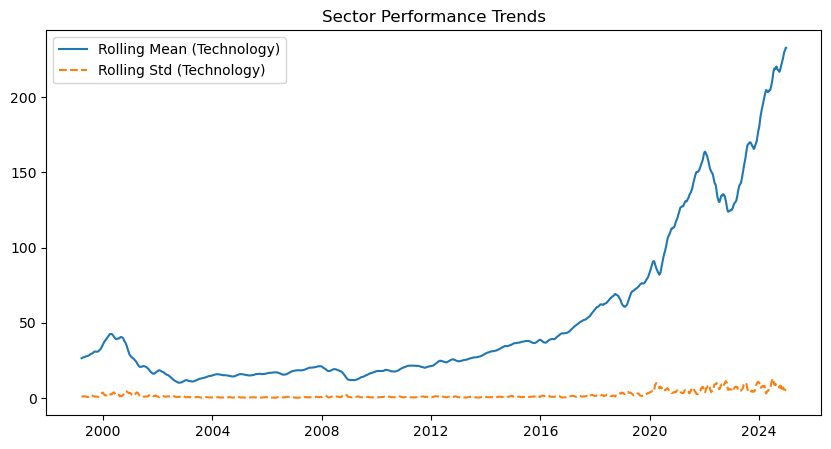

In [1112]:
# Rolling statistics for trend analysis
rolling_mean = df_sector.rolling(window=12).mean()
rolling_std = df_sector.rolling(window=12).std()

plt.figure(figsize=(10, 5))
plt.plot(df_sector.index, rolling_mean["Technology"], label="Rolling Mean (Technology)")
plt.plot(df_sector.index, rolling_std["Technology"], label="Rolling Std (Technology)", linestyle="dashed")
plt.legend()
plt.title("Sector Performance Trends")
plt.show()

- Technology sector steadily grew, with rapid rise post-2016.

- Volatility remained mostly low, except for a bump in recent years, likely due to economic shocks (e.g., COVID-19, inflation, Fed policy shifts).

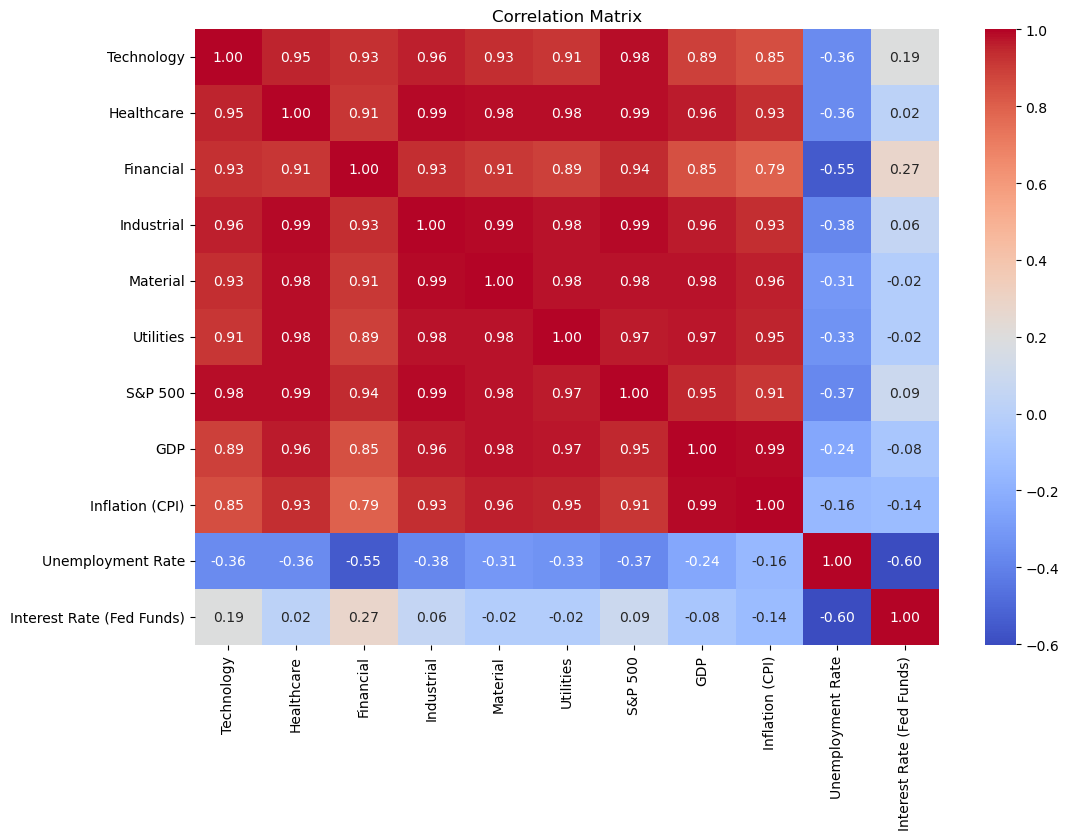

In [392]:
#2. Correlation Analysis

# Pearson correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- GDP is highly correlated with sectors like Material (0.98), Industrial (0.96), and S&P 500 (0.95).

- Unemployment Rate negatively correlates with: GDP (-0.24), Financials (-0.55), S&P 500 (-0.37)and Interest Rate negatively correlates with Unemployment (-0.60).

- When GDP rises, sectors and stock market rise.

- When unemployment increases, markets and GDP fall.

- The Fed lowers interest rates during high unemployment to boost the economy.

## Classify Economic Phases

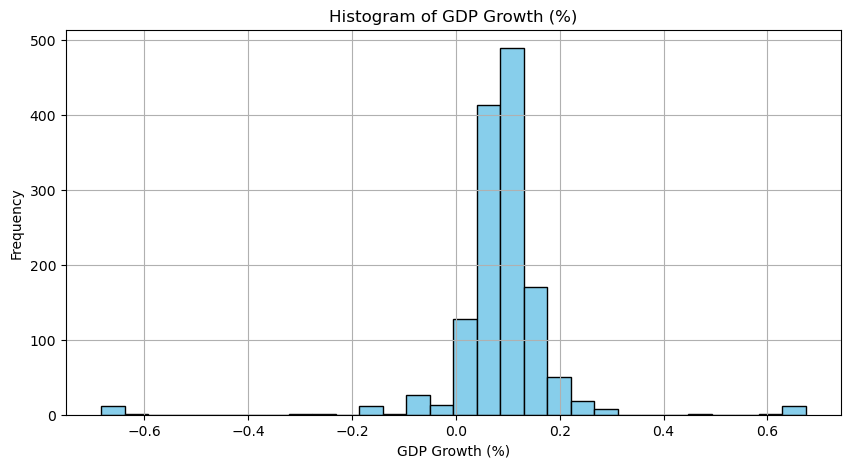

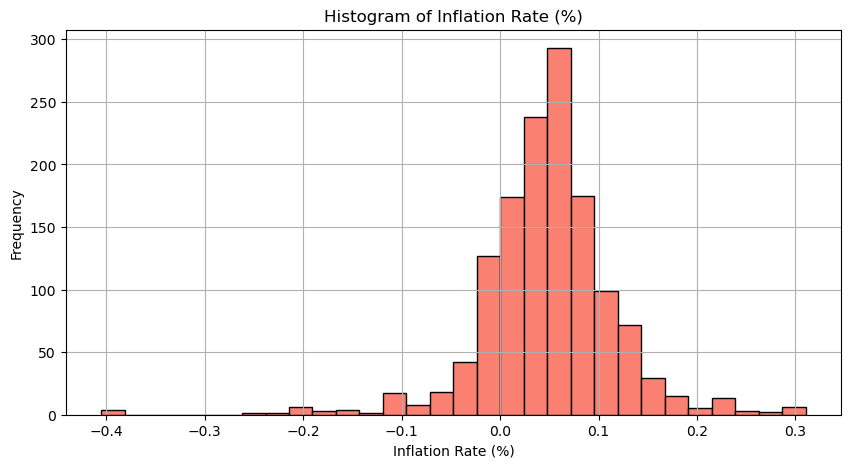

In [5]:
# Load macroeconomic data
df_macro = pd.read_csv("Macroeconomic_Data.csv", index_col="Date", parse_dates=True)

# Calculate percentage changes
df_macro["GDP Growth (%)"] = df_macro["GDP"].pct_change() * 100
df_macro["Inflation Rate (%)"] = df_macro["Inflation (CPI)"].pct_change() * 100

# Plot histogram for GDP Growth (%)
plt.figure(figsize=(10, 5))
plt.hist(df_macro["GDP Growth (%)"].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of GDP Growth (%)")
plt.xlabel("GDP Growth (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot histogram for Inflation Rate (%)
plt.figure(figsize=(10, 5))
plt.hist(df_macro["Inflation Rate (%)"].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title("Histogram of Inflation Rate (%)")
plt.xlabel("Inflation Rate (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [395]:
# Define classification logic using percentage changes
def classify_economic_phase(row):
    gdp = row["GDP Growth (%)"]
    inflation = row["Inflation Rate (%)"]
    unemployment = row["Unemployment Rate"]
    interest = row["Interest Rate (Fed Funds)"]

    # Expansion
    if gdp > 0.1 and unemployment < 4:
        return "Expansion"

    # Peak
    elif gdp > 0  and inflation > 0.1 and  interest > 3:
        return "Peak"

    # Recession / Contraction
    elif gdp < 0 and unemployment > 5:
        return "Recession"

    # Recovery / Trough
    else:
        return "Recovery"

# Apply classification to dataset
df_macro["Economic Phase"] = df_macro.apply(classify_economic_phase, axis=1)

# Save classification results to a CSV file
df_macro.to_csv("Economic_Phases.csv", index=True)

print("Economic phases saved successfully!")

Economic phases saved successfully!


In [396]:
# Display results
df_macro.head(10)

,GDP,Inflation (CPI),Unemployment Rate,Interest Rate (Fed Funds),GDP Growth (%),Inflation Rate (%),Economic Phase
Date,,,,,,,
1999-01-01,9411.682000,164.700000,4.300000,4.63,NaN,NaN,Recovery
1999-01-08,9420.589733,164.700000,4.322581,4.63,0.094645,0.000000,Recovery
1999-01-15,9429.497467,164.700000,4.345161,4.63,0.094556,0.000000,Recovery
1999-01-22,9438.405200,164.700000,4.367742,4.63,0.094467,0.000000,Recovery
1999-01-29,9447.312933,164.700000,4.390323,4.63,0.094378,0.000000,Recovery
1999-02-05,9456.220667,164.714286,4.371429,4.76,0.094289,0.008674,Recovery
1999-02-12,9465.128400,164.739286,4.321429,4.76,0.094200,0.015178,Recovery
1999-02-19,9474.036133,164.764286,4.271429,4.76,0.094111,0.015175,Recovery
1999-02-26,9482.943867,164.789286,4.221429,4.76,0.094023,0.015173,Recovery


## Data Preprocessing 

In [986]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [987]:
# Load and preprocess macroeconomic data
df = pd.read_csv("Macroeconomic_Data.csv", index_col="Date", parse_dates=True)

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Convert data to time-series format
def create_sequences(data, seq_length=12):  # 12-month sequences
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(df_scaled, seq_length)

# Split into train & test
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [1366]:
import joblib

# Save the fitted scaler to a file
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


## LSTM Model 

In [1021]:
# 1. LSTM Model for Time-Series Forecasting
lstm_model = Sequential([
    LSTM(64, activation="relu", return_sequences=True, input_shape=(seq_length, X.shape[2])),
    LSTM(64, activation="relu"),
    Dropout(0.01),
    Dense(y.shape[1])  # Output layer
])

lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
lstm_model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test))

# Predictions
y_pred_lstm = lstm_model.predict(X_test)

Epoch 1/40


C:\Users\nikit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0516 - mae: 0.1610 - val_loss: 0.0569 - val_mae: 0.1827
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 0.0431 - val_mae: 0.1470
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3827e-04 - mae: 0.0204 - val_loss: 0.0291 - val_mae: 0.1242
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9315e-04 - mae: 0.0150 - val_loss: 0.0280 - val_mae: 0.1218
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.3029e-04 - mae: 0.0160 - val_loss: 0.0176 - val_mae: 0.0947
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8426e-04 - mae: 0.0156 - val_loss: 0.0202 - val_mae: 0.1049
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3097e-04 - mae: 0.0147 - val_loss: 0.0129 - val_mae: 0.0786
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8576e-04 - mae: 0.0155 - val_loss: 0.0119 - val_mae: 0.0765
Epoch 9/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 

In [1364]:
# Saved the lstm model
lstm_model.save("lstm_model.keras") 
print("LSTM Model is saved successfully!")

LSTM Model is saved successfully!


##  Transformer Model

In [994]:
# 2. Transformer Model for Long-Term Dependencies
class TransformerTimeSeries(tf.keras.Model):
    def __init__(self, seq_length=12, feature_dim=4, **kwargs):
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.feature_dim = feature_dim
        self.encoder_layer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=feature_dim)
        self.dense_layer = tf.keras.layers.Dense(feature_dim, activation="relu")

    def call(self, inputs):
        x = self.encoder_layer(inputs, inputs)
        x = self.dense_layer(x)
        return x[:, -1, :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "seq_length": self.seq_length,
            "feature_dim": self.feature_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Instantiate transformer model
transformer_model = TransformerTimeSeries(seq_length, X.shape[2])
transformer_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train Transformer model
transformer_model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test))

# Predictions
y_pred_transformer = transformer_model(X_test)    

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0449 - mae: 0.1586 - val_loss: 0.0698 - val_mae: 0.2375
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0099 - mae: 0.0793 - val_loss: 0.0355 - val_mae: 0.1618
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - mae: 0.0461 - val_loss: 0.0144 - val_mae: 0.0965
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - mae: 0.0286 - val_loss: 0.0070 - val_mae: 0.0582
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.2811e-04 - mae: 0.0208 - val_loss: 0.0049 - val_mae: 0.0423
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1447e-04 - mae: 0.0159 - val_loss: 0.0048 - val_mae: 0.0405
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3610e-04 - mae: 0.0140 - val_loss: 0.0048 - val_mae: 0.0390
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0958e-04 - mae: 0.0131 - val_loss: 0.0046 - val_mae: 0.0371
Epoch 9/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/ste

In [1365]:
# Saved the Transformer Model
transformer_model.save_weights("transformer_model.weights.h5") 
print("Transformer Model is saved successfully!")

Transformer Model is saved successfully!


## Model Evaluation 

In [1041]:
# 3. Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
evaluate_model(y_test, y_pred_lstm, "LSTM")
evaluate_model(y_test, y_pred_transformer, "Transformer")

LSTM - RMSE: 0.0825, MAE: 0.0542, R²: 0.8479
Transformer - RMSE: 0.0507, MAE: 0.0271, R²: 0.9455


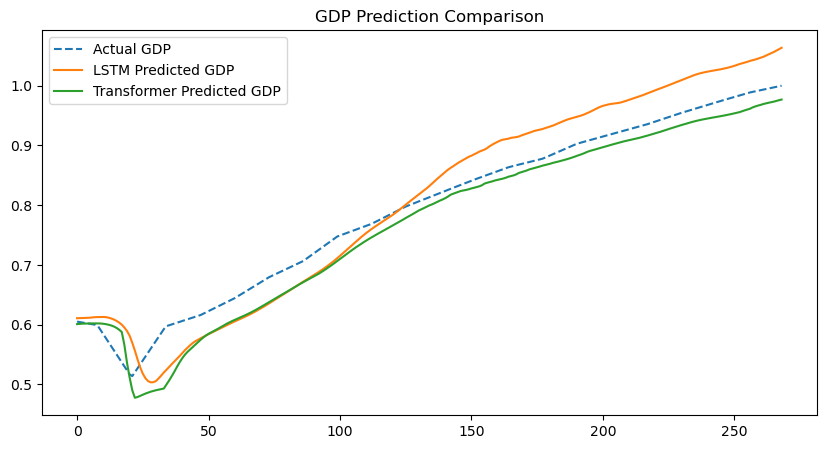

In [1363]:
# 4. Visualization
plt.figure(figsize=(10, 5))
plt.plot(y_test[:, 0], label="Actual GDP", linestyle="dashed")
plt.plot(y_pred_lstm[:, 0], label="LSTM Predicted GDP")
plt.plot(y_pred_transformer[:, 0], label="Transformer Predicted GDP")
plt.legend()
plt.title("GDP Prediction Comparison")
plt.show()

## Simplified Q-Learning for Sector Allocation

In [1372]:
import random

# Load data: macroeconomic phases
df_phases = pd.read_csv("Economic_Phases.csv", index_col="Date", parse_dates=True)

# Compute weekly percentage returns
returns = df_sector.pct_change().dropna()

# Merge with economic phases
df_combined = returns.join(df_phases["Economic Phase"]).dropna()

# Calculate average sector returns per economic phase
reward_matrix = df_combined.groupby("Economic Phase").mean()
reward_map = reward_matrix.to_dict(orient="index")

states = reward_matrix.index.tolist()  # [Phases]
actions = reward_matrix.columns.tolist()  # [sectors]

Q = np.zeros((len(states), len(actions)))

alpha = 0.1   # learning rate(0.1)
gamma = 0.99   # discount factor(0.9)
episodes = 10000 # more episodes = more stable learning

for ep in range(episodes):
    state = random.choice(states)
    action_idx = random.randint(0, len(actions)-1)
    action = actions[action_idx]

    reward = reward_map.get(state, {}).get(action, 0.1)
    next_state = random.choice(states)
    best_next = np.max(Q[states.index(next_state)])
    Q[states.index(state), action_idx] += alpha * (
        reward + gamma * best_next - Q[states.index(state), action_idx]
    )

# Extract learned policy
best_actions = np.argmax(Q, axis=1)

policy = {states[i]: actions[best_actions[i]] for i in range(len(states))}

# Display final policy
print("Learned Policy (based on historical sector performance):")
for state, action in policy.items():
    print(f"{state}: {action}")

Learned Policy (based on historical sector performance):
Expansion: Industrial
Peak: Technology
Recession: Healthcare
Recovery: Financial


In [1373]:
# Save Q-matrix (as .npy)
np.save("Q_matrix.npy", Q)

# Save policy dictionary (as .pkl)
with open("sector_policy.pkl", "wb") as f:
    pickle.dump(policy, f)

print("Q-matrix saved to 'Q_matrix.npy'")
print("Policy saved to 'sector_policy.pkl'")

Q-matrix saved to 'Q_matrix.npy'
Policy saved to 'sector_policy.pkl'


## Portfolio Optimization (Modern Portfolio Theory)

In [1120]:
from scipy.optimize import minimize

# Load weekly sector ETF data
df = pd.read_csv("Sector_ETF_Data.csv", index_col="Date", parse_dates=True)
returns = np.log(df / df.shift(1)).dropna()
returns = returns.rolling(12).mean().dropna()  # 12-week moving average

# Annualize mean returns and covariance matrix
mean_returns = returns.mean() * 52  # Weekly to annual
cov_matrix = returns.cov() * 52

# Risk-free rate (e.g., 13-week T-bill ~1% annualized)
rf = 0.01

# Number of assets (ETFs)
n = len(mean_returns)
init_weights = np.ones(n) / n  # Start with equal weights

# Bounds and constraint: weights must sum to 1 and be between 0 and 1
bounds = tuple((0, 1) for _ in range(n))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Objective: Maximize Sharpe Ratio (i.e., minimize negative)
def negative_sharpe(weights):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - rf) / port_vol
    return -sharpe

# Run optimization
result = minimize(negative_sharpe, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = result.x

# Compute portfolio stats
annual_return = np.dot(opt_weights, mean_returns)
annual_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix, opt_weights)))
sharpe_ratio = (annual_return - rf) / annual_volatility

# Create portfolio return series
portfolio_returns_series = returns.dot(opt_weights)
cumulative_return = (1 + portfolio_returns_series).prod() - 1

# Display results
print("Optimized Portfolio Performance Metrics:\n")
print(f"Portfolio Return (Annualized)    : {annual_return:.4f}")
print(f"Portfolio Volatility (Annualized): {annual_volatility:.4f}")
print(f"Sharpe Ratio                     : {sharpe_ratio:.4f}")
print(f"Cumulative Return (Total)        : {cumulative_return:.4f}")

Optimized Portfolio Performance Metrics:

Portfolio Return (Annualized)    : 0.0770
Portfolio Volatility (Annualized): 0.0360
Sharpe Ratio                     : 1.8592
Cumulative Return (Total)        : 6.1861


## Economic Phase Prediction & Sector Allocation 

In [1125]:
# 1. Load macroeconomic data
df_macro = pd.read_csv("Macroeconomic_Data.csv", index_col="Date", parse_dates=True)

features = ["GDP", "Inflation (CPI)", "Unemployment Rate", "Interest Rate (Fed Funds)"]
recent_data = df_macro[features].dropna()

# 2. Scale and prepare input
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(recent_data)

def create_latest_sequence(data, seq_length=12):
    return np.expand_dims(data[-seq_length:], axis=0)  # (1, seq_len, n_features)

seq_input = create_latest_sequence(data_scaled)

# 3. Used Transformer model to predict
predicted_values = transformer_model.predict(seq_input)
predicted_values = scaler.inverse_transform(predicted_values)[0]
predicted_dict = dict(zip(features, predicted_values))

# 4. Classify phase based on prediction
def classify_economic_phase(row_dict):
    gdp = row_dict["GDP"]
    unemployment = row_dict["Unemployment Rate"]
    inflation = row_dict["Inflation (CPI)"]
    interest = row_dict["Interest Rate (Fed Funds)"]

    if gdp > 2.5 and unemployment < 4:
        return "Expansion"
    elif gdp > 0 and inflation > 3 and interest > 4:
        return "Peak"
    elif gdp < 0 and unemployment > 5:
        return "Recession"
    else:
        return "Recovery"
    
    
predicted_dict = dict(zip(features, predicted_values))
economic_phase = classify_economic_phase(predicted_dict)

# Define FRED macroeconomic indicators
fred_symbols = {
    'GDP': 'GDP',
    'Inflation (CPI)': 'CPIAUCSL',
    'Unemployment Rate': 'UNRATE',
    'Interest Rate (Fed Funds)': 'FEDFUNDS'
}

# Fetch the most recent available real values from FRED
actual_values = {}
for feature, symbol in fred_symbols.items():
    try:
        data = web.DataReader(symbol, "fred")
        latest_val = data.dropna().iloc[-1].values[0]
        actual_values[feature] = latest_val
    except Exception as e:
        print(f"Error fetching {feature}: {e}")
        actual_values[feature] = None
        
        
# Predicted Values 
print("Predicted Macroeconomic Values")
for feature in features:
    print(f"{feature}: {predicted_dict[feature]:.2f}")

predicted_phase = classify_economic_phase(predicted_dict)
predicted_sector = policy.get(predicted_phase, "S&P 500")

print(f"\nPredicted Economic Phase: {predicted_phase}")
print(f"Recommended Sector to Overweight: {predicted_sector}")
print("__________________________________________________________________")

# Actual Values 
print("\nActual Macroeconomic Values (Most Recent from FRED)")
actual_dict = {}
for feature in features:
    actual_val = actual_values.get(feature, None)
    if actual_val is not None:
        actual_dict[feature] = actual_val
        print(f"{feature}: {actual_val:.2f}")
    else:
        print(f"{feature}: Not Available")

if len(actual_dict) == len(features):
    actual_phase = classify_economic_phase(actual_dict)
    actual_sector = policy.get(actual_phase, "S&P 500")

    print(f"\nActual Economic Phase: {actual_phase}")
    print(f"Recommended Sector to Overweight: {actual_sector}")
else:
    print("\nActual Economic Phase: Cannot determine (missing data)")

print("__________________________________________________________________")    
    
# Optional: Error Comparison 
print("\nError (Predicted - Actual)")
for feature in features:
    pred_val = predicted_dict[feature]
    actual_val = actual_values.get(feature, None)
    if actual_val is not None:
        error = pred_val - actual_val
        print(f"{feature}: Error = {error:.2f}")
    else:
        print(f"{feature}: Error = Cannot compute (Actual not available)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Macroeconomic Values
GDP: 29512.48
Inflation (CPI): 319.15
Unemployment Rate: 3.86
Interest Rate (Fed Funds): 4.47

Predicted Economic Phase: Peak
Recommended Sector to Overweight: Technology
__________________________________________________________________

Actual Macroeconomic Values (Most Recent from FRED)
GDP: 29962.05
Inflation (CPI): 320.58
Unemployment Rate: 4.20
Interest Rate (Fed Funds): 4.33

Actual Economic Phase: Peak
Recommended Sector to Overweight: Technology
__________________________________________________________________

Error (Predicted - Actual)
GDP: Error = -449.57
Inflation (CPI): Error = -1.43
Unemployment Rate: Error = -0.34
Interest Rate (Fed Funds): Error = 0.14


## Predicted vs Actual Macroeconomic Indicators

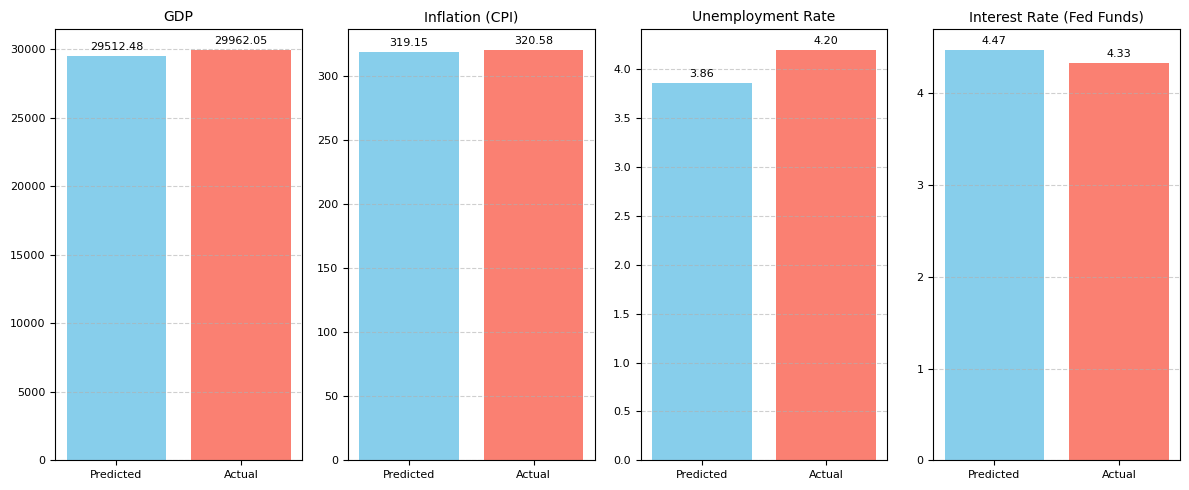

In [1362]:
# Prepare data
feature_labels = features
predicted_vals = [predicted_dict[feature] for feature in features]
actual_vals = [actual_values.get(feature, np.nan) for feature in features]

# Create a single row of subplots
fig, axes = plt.subplots(1, len(feature_labels), figsize=(12, 5))  # Width x Height

for i, ax in enumerate(axes):
    feature = feature_labels[i]
    pred = predicted_vals[i]
    actual = actual_vals[i]

    # Bar chart for each feature
    bars = ax.bar(['Predicted', 'Actual'], [pred, actual], color=['skyblue', 'salmon'])

    ax.set_title(f'{feature}', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Annotate values on bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()